# UNIVERSIDAD TECNOLÓGICA NACIONAL

# Facultad Regional Buenos Aires

## Teoría de los Circuitos II

## Año 2022

### Trabajo Semanal Nº9

### Profesor: Mariano Llamedo Soria 

### Ayudante: Eugenia Ipar

### Giuliana Ruffa (Legajo: 1774463) 

###### Parte 1: Diseño de filtros

Se necesita eliminar las interferencias de una señal electrocardiográfica (ECG) que fue registrada a una frecuencia de muestreo de 1 kHz. Para ello se propone la siguiente plantilla de diseño:

In [21]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from splane import plot_plantilla

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

ImportError: cannot import name 'plot_plantilla' from 'splane' (/Users/giulianaruffa/Documents/GitHub/TCII_FRBA_2022/TS9/splane.py)

In [19]:
# Plantilla

# filter design
ripple = 0 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)

NameError: name 'nyq_frec' is not defined

y se pide diseñar dos filtros: uno IIR y otro FIR que cumplan con la plantilla, utilizando alguno de los métodos estudiados. Mostrar la respuesta en frecuencia, para ambos filtros, de:

a) módulo, 

b) fase 

c) retardo 

d) y respuesta al impulso.

###### Resolución: IIR

Resolvemos a partir de un diseño H(S) y convirtiéndolo en un filtro digital mediante la transformada bilineal.

A partir de la plantilla, observamos que fs= 25Hz, fp= 40Hz, $\alpha _{max}$ =0 y $\alpha _{min}$ =40dB . Luego, por el $\alpha _{max}$ =0 decidimos utilizar la aproximación de Butterworth y por $\alpha _{min}$ =40dB calculamos que necesitaremos un filtro de N=10.

A partir de esto, calculamos el pasa bajos y lo convertimos. Observamos su comportamiento en el plano S:

<IPython.core.display.Math object>

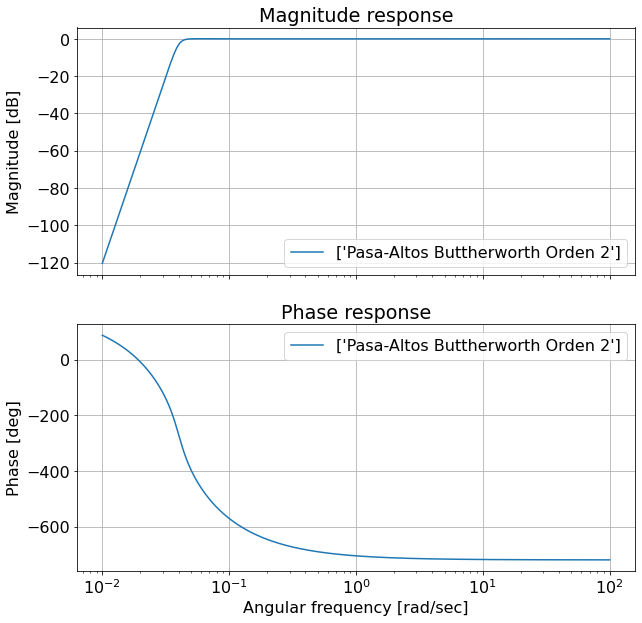

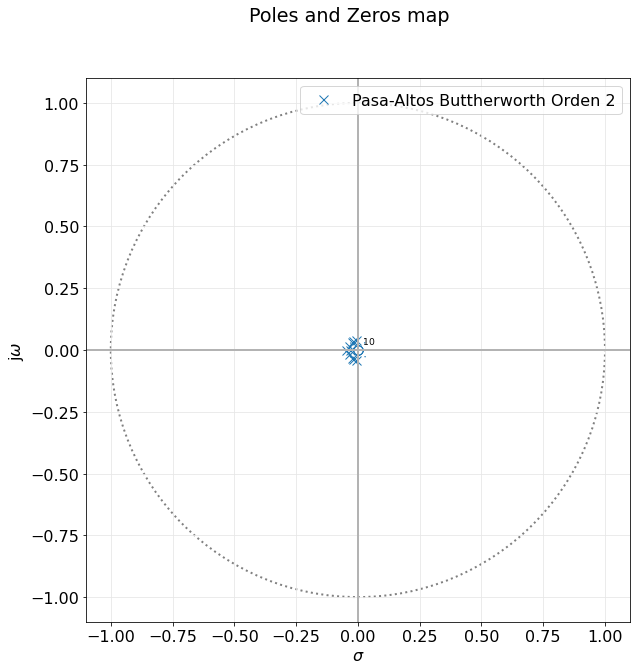

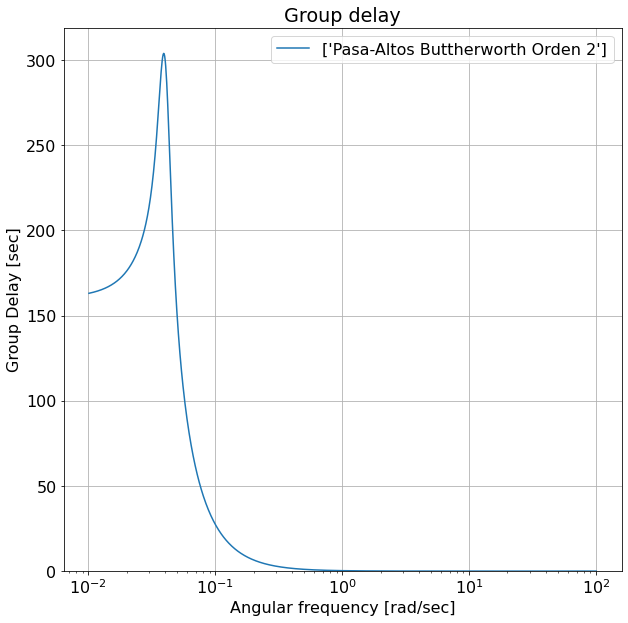

In [65]:
# Plano de Laplace
# Módulos para Jupyter

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
#%%  Inicialización de librerías
# Setup inline graphics: Esto lo hacemos para que el tamaño de la salida, 
# sea un poco más adecuada al tamaño del documento
mpl.rcParams['figure.figsize'] = (10,10)

#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi

fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})


# módulo de SciPy
from scipy import signal as sig

# un módulo adaptado a mis necesidades
from splane import analyze_sys, pretty_print_bicuad_omegayq, pretty_print_lti

numpb = np.array ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1*25**10])
denpb = np.array ([1, 6.4*25, 20.43*25**2, 42.8*25**3, 64.88*25**4, 74.23*25**5, 64.88*25**6, 42.8*25**7, 20.43*25**8, 6.4*25**9, 1*25**10])

num = np.array ([1*25**10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
den = np.array ([1*25**10, 6.39*25**9, 20.43*25**8, 42.8*25**7, 64.88*25**6, 74.23*25**5, 64.88*25**4, 42.8*25**3, 20.43*25**2, 6.39*25**1, 1])

#num = np.array ([1, 0, 0])
#den = np.array ([1, 30*np.sqrt(2), 900])

rf = sig.TransferFunction(num,den)
pretty_print_lti(rf)

    
analyze_sys(rf, 'Pasa-Altos Buttherworth Orden 10')

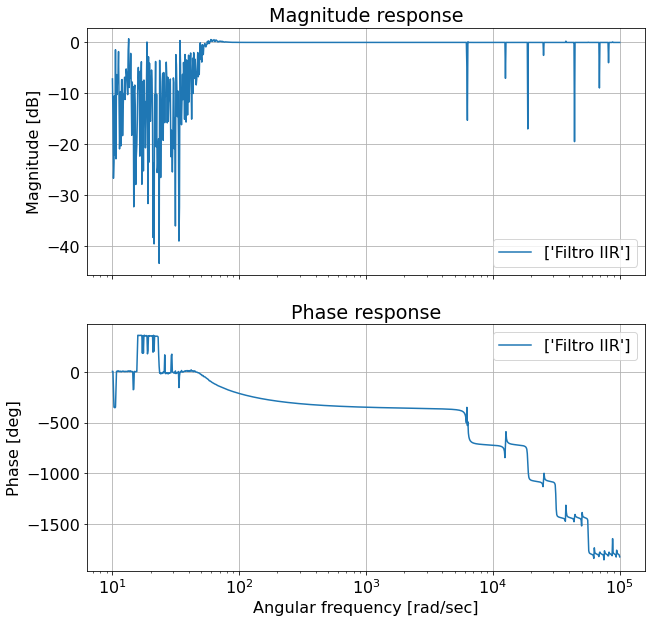

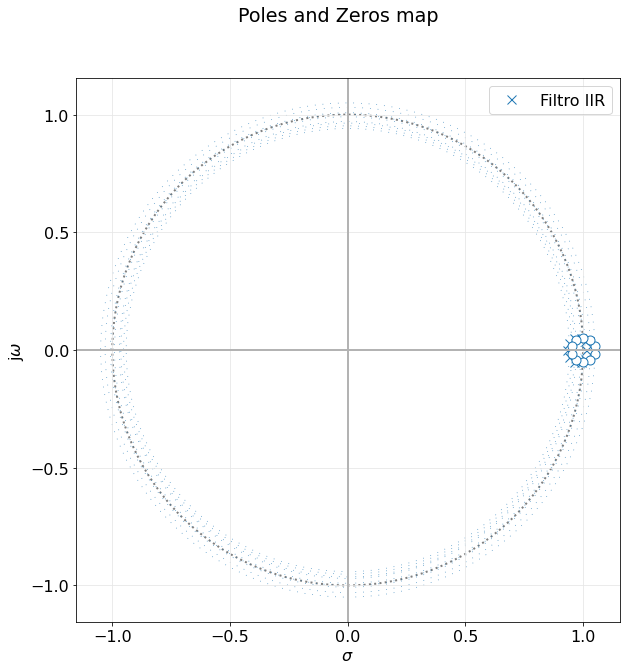

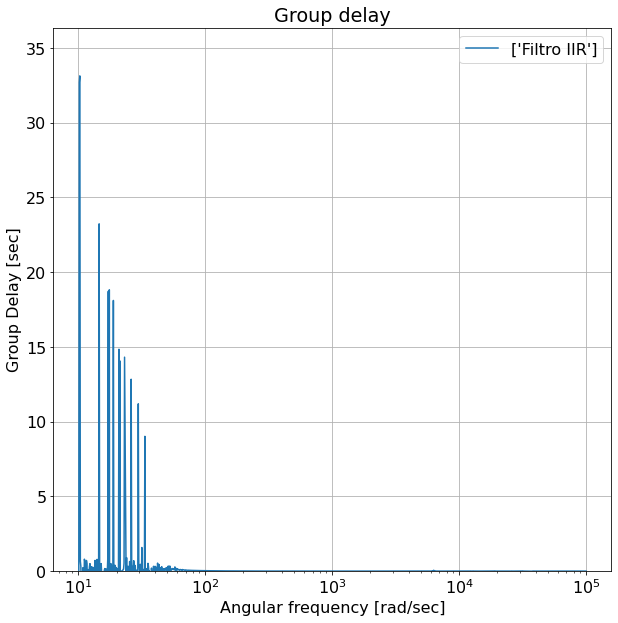

In [66]:
# Plano Z
# Módulos para Jupyter

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
#%%  Inicialización de librerías
# Setup inline graphics: Esto lo hacemos para que el tamaño de la salida, 
# sea un poco más adecuada al tamaño del documento
mpl.rcParams['figure.figsize'] = (10,10)

#%% Esto tiene que ver con cuestiones de presentación de los gráficos,
# NO ES IMPORTANTE
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi

fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})


# módulo de SciPy
from scipy import signal as sig

# un módulo adaptado a mis necesidades
from splane import analyze_sys, pretty_print_bicuad_omegayq, pretty_print_lti

num = np.array ([1*25**10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
den = np.array ([1*25**10, 6.39*25**9, 20.43*25**8, 42.8*25**7, 64.88*25**6, 74.23*25**5, 64.88*25**4, 42.8*25**3, 20.43*25**2, 6.39*25**1, 1])


#pretty_print_lti(rf)

fs = 1000 # Hz
numz, denz = sig.bilinear (num, den, fs=1)
digital_iir = sig.TransferFunction(numz,denz, dt=1/fs)
analyze_sys(digital_iir, 'Filtro IIR')

#print (np.roots (denz))
#print (np.roots (numz))

